In [ ]:
#zda23m007----Arpit--Shukla

In [1]:
import numpy as np
import tensorflow as tf
import gym

class ValueNetwork():
    def __init__(self, num_features, hidden_size, learning_rate=.01):
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.tf_graph = tf.Graph()
        with self.tf_graph.as_default():
            tf.compat.v1.disable_eager_execution()
            self.session = tf.compat.v1.Session()

            self.observations = tf.compat.v1.placeholder(shape=[None, self.num_features], dtype=tf.float32)
            self.W = [
                tf.compat.v1.get_variable("W1", shape=[self.num_features, self.hidden_size]),
                tf.compat.v1.get_variable("W2", shape=[self.hidden_size, 1])
            ]
            self.layer_1 = tf.nn.sigmoid(tf.matmul(self.observations, self.W[0]))
            self.output = tf.reshape(tf.matmul(self.layer_1, self.W[1]), [-1])

            self.rollout = tf.compat.v1.placeholder(shape=[None], dtype=tf.float32)
            self.loss = tf.compat.v1.losses.mean_squared_error(self.output, self.rollout)
            self.grad_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
            self.minimize = self.grad_optimizer.minimize(self.loss)

            init = tf.compat.v1.global_variables_initializer()
            self.session.run(init)

    def get(self, states):
        value = self.session.run(self.output, feed_dict={self.observations: states})
        return value

    def update(self, states, discounted_rewards):
        _, loss = self.session.run([self.minimize, self.loss], feed_dict={
            self.observations: states, self.rollout: discounted_rewards
        })


class PPOPolicyNetwork():
    def __init__(self, num_features, layer_1_size, layer_2_size, layer_3_size, num_actions, epsilon=.2,
                 learning_rate=9e-4):
        self.tf_graph = tf.Graph()

        with self.tf_graph.as_default():
            tf.compat.v1.disable_eager_execution()
            self.session = tf.compat.v1.Session()

            self.observations = tf.compat.v1.placeholder(shape=[None, num_features], dtype=tf.float32)
            self.W = [
                tf.compat.v1.get_variable("W1", shape=[num_features, layer_1_size], initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform")),
                tf.compat.v1.get_variable("W2", shape=[layer_1_size, layer_2_size], initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform")),
                tf.compat.v1.get_variable("W3", shape=[layer_2_size, layer_3_size], initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform")),
                tf.compat.v1.get_variable("W4", shape=[layer_3_size, num_actions], initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
            ]

            self.output = tf.nn.relu(tf.matmul(self.observations, self.W[0]))
            self.output = tf.nn.relu(tf.matmul(self.output, self.W[1]))
            self.output = tf.nn.relu(tf.matmul(self.output, self.W[2]))
            self.output = tf.nn.softmax(tf.matmul(self.output, self.W[3]))

            self.advantages = tf.compat.v1.placeholder(shape=[None], dtype=tf.float32)

            self.chosen_actions = tf.compat.v1.placeholder(shape=[None, num_actions], dtype=tf.float32)
            self.old_probabilities = tf.compat.v1.placeholder(shape=[None, num_actions], dtype=tf.float32)

            self.new_responsible_outputs = tf.reduce_sum(self.chosen_actions*self.output, axis=1)
            self.old_responsible_outputs = tf.reduce_sum(self.chosen_actions*self.old_probabilities, axis=1)

            self.ratio = self.new_responsible_outputs/self.old_responsible_outputs

            self.loss = tf.reshape(
                            tf.minimum(
                                tf.multiply(self.ratio, self.advantages),
                                tf.multiply(tf.clip_by_value(self.ratio, 1-epsilon, 1+epsilon), self.advantages)),
                            [-1]
                        )
            self.loss = -tf.reduce_mean(self.loss)

            self.W0_grad = tf.compat.v1.placeholder(dtype=tf.float32)
            self.W1_grad = tf.compat.v1.placeholder(dtype=tf.float32)
            self.W2_grad = tf.compat.v1.placeholder(dtype=tf.float32)
            self.W3_grad = tf.compat.v1.placeholder(dtype=tf.float32)

            self.gradient_placeholders = [self.W0_grad, self.W1_grad, self.W2_grad, self.W3_grad]
            self.trainable_vars = self.W
            self.gradients = [(np.zeros(var.get_shape()), var) for var in self.trainable_vars]

            self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
            self.get_grad = self.optimizer.compute_gradients(self.loss, self.trainable_vars)
            self.apply_grad = self.optimizer.apply_gradients(zip(self.gradient_placeholders, self.trainable_vars))
            init = tf.compat.v1.global_variables_initializer()
            self.session.run(init)

    def get_dist(self, states):
        dist = self.session.run(self.output, feed_dict={self.observations: states})
        return dist

    def update(self, states, chosen_actions, ep_advantages):
        old_probabilities = self.session.run(self.output, feed_dict={self.observations: states})
        self.session.run(self.apply_grad, feed_dict={
            self.W0_grad: self.gradients[0][0],
            self.W1_grad: self.gradients[1][0],
            self.W2_grad: self.gradients[2][0],
            self.W3_grad: self.gradients[3][0],
        })
        self.gradients, loss = self.session.run([self.get_grad, self.output], feed_dict={
            self.observations: states,
            self.advantages: ep_advantages,
            self.chosen_actions: chosen_actions,
            self.old_probabilities: old_probabilities
        })


class PPO():
    def __init__(self, env, num_features=1, num_actions=1, gamma=.98, lam=1, epsilon=.2,
                 value_network_lr=0.1, policy_network_lr=9e-4, value_network_hidden_size=100,
                 policy_network_hidden_size_1=10, policy_network_hidden_size_2=10, policy_network_hidden_size_3=10):

        self.env = env
        self.num_features = num_features
        self.num_actions = num_actions
        self.gamma = gamma
        self.lam = lam
        self.Pi = PPOPolicyNetwork(num_features=num_features, num_actions=num_actions,
                                   layer_1_size=policy_network_hidden_size_1,
                                   layer_2_size=policy_network_hidden_size_2,
                                   layer_3_size=policy_network_hidden_size_3,
                                   epsilon=epsilon,
                                   learning_rate=policy_network_lr)
        self.V = ValueNetwork(num_features, value_network_hidden_size, learning_rate=value_network_lr)

    def discount_rewards(self, rewards):
        running_total = 0
        discounted = np.zeros_like(rewards)
        for r in reversed(range(len(rewards))):
            running_total = running_total * self.gamma + rewards[r]
            discounted[r] = running_total
        return discounted

    def calculate_advantages(self, rewards, values):
        advantages = np.zeros_like(rewards)
        for t in range(len(rewards)):
            ad = 0
            for l in range(0, len(rewards) - t - 1):
                delta = rewards[t+l] + self.gamma*values[t+l+1] - values[t+l]
                ad += ((self.gamma*self.lam)**l)*(delta)
            ad += ((self.gamma*self.lam)**l)*(rewards[t+l] - values[t+l])
            advantages[t] = ad
        return (advantages - np.mean(advantages))/np.std(advantages)


    def run_model(self):
        episode = 1
        running_reward = []
        step = 0
        render = False
        while(True):
            s0 = self.env.reset()
            is_terminal = False
            ep_rewards = []
            ep_actions = []
            ep_states = []
            score = 0
            while not is_terminal:
                if render:
                    self.env.render()
                action = np.random.choice(range(self.num_actions), p=self.Pi.get_dist(np.array(s0)[np.newaxis, :])[0])
                a_binarized = np.zeros(self.num_actions)
                a_binarized[action] = 1
                s1, r, is_terminal, _ = self.env.step(action)
                score += r
                ep_actions.append(a_binarized)
                ep_rewards.append(r)
                ep_states.append(s0)
                s0 = s1
                if is_terminal:
                    ep_actions = np.vstack(ep_actions)
                    ep_rewards = np.array(ep_rewards, dtype=np.float_)
                    ep_states = np.vstack(ep_states)
                    targets = self.discount_rewards(ep_rewards)
                    for i in range(len(ep_states)):
                        self.V.update([ep_states[i]], [targets[i]])
                    ep_advantages = self.calculate_advantages(ep_rewards, self.V.get(ep_states))
                    vs = self.V.get(ep_states)
                    self.Pi.update(ep_states, ep_actions, ep_advantages)
                    ep_rewards = []
                    ep_actions = []
                    ep_states = []
                    running_reward.append(score)
                    if episode % 25 == 0:
                        avg_score = np.mean(running_reward[-25:])
                        print("Episode: " + str(episode) + " Score: " + str(avg_score))
                        if avg_score >= 500:
                            print("Solved!")
                            render = True
                    episode += 1

env = gym.make('CartPole-v1')
agent = PPO(env, num_features=4, num_actions=2, gamma=.98, lam=1, epsilon=.2,
            value_network_lr=0.001, policy_network_lr=.01, value_network_hidden_size=100,
            policy_network_hidden_size_1=40, policy_network_hidden_size_2=35, policy_network_hidden_size_3=30)
agent.run_model()



/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 25 Score: 25.12
Episode: 50 Score: 23.76
Episode: 75 Score: 52.24
Episode: 100 Score: 256.88
Episode: 125 Score: 387.52
Episode: 150 Score: 433.84
Episode: 175 Score: 484.48
Episode: 200 Score: 490.72
Episode: 225 Score: 410.56
Episode: 250 Score: 427.0
Episode: 275 Score: 445.72
Episode: 300 Score: 420.88
Episode: 325 Score: 482.88
Episode: 350 Score: 500.0
Solved!


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


KeyboardInterrupt: 

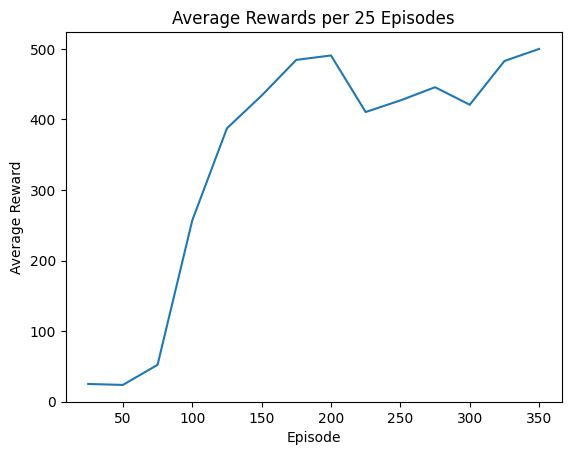

In [2]:
import matplotlib.pyplot as plt

# List of average scores every 25 episodes
rewards_history = [25.12, 23.76, 52.24, 256.88, 387.52, 433.84, 484.48, 490.72, 410.56, 427.0, 445.72, 420.88, 482.88, 500.0]

def plot_rewards(rewards_history):
    episodes = [i * 25 for i in range(1, len(rewards_history) + 1)]
    plt.plot(episodes, rewards_history)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Average Rewards per 25 Episodes')
    plt.show()

plot_rewards(rewards_history)
